In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest


In [26]:
# Load user dataset
df = pd.read_csv("C:\\Users\\KIIT\\Downloads\\college_student_expenses.csv")

# Convert Date to datetime format
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y", dayfirst=True)

# Display first few rows
df.head()


,Date,Description,Amount,Category
0,2024-11-01,Street food,90.0,Food & Dining
1,2024-11-01,Bus fare,30.0,Transport
2,2024-11-03,Concert,350.0,Entertainment
3,2024-11-04,Printing,20.0,Utilities
4,2024-11-04,Milk & dairy,40.0,Groceries


                    --------------------------------Isolation Forest for Anomaly Detection----------------------------------------

In [29]:

iso_forest = IsolationForest(contamination=0.05, random_state=42)  # 5% data marked as anomalies

iso_forest.fit(df[["Amount"]])
df["Anomaly"] = iso_forest.predict(df[["Amount"]])
anomalies = df[df["Anomaly"] == -1]

anomalies


,Date,Description,Amount,Category,Anomaly
8,2024-11-09,Salon visit,358.97,Personal Care,-1
34,2024-12-17,Milk & dairy,394.54,Groceries,-1
62,2025-01-25,Pen purchase,10.00,Utilities,-1
64,2025-01-29,Fast food,308.30,Food & Dining,-1
76,2025-02-13,Haircut,450.00,Personal Care,-1


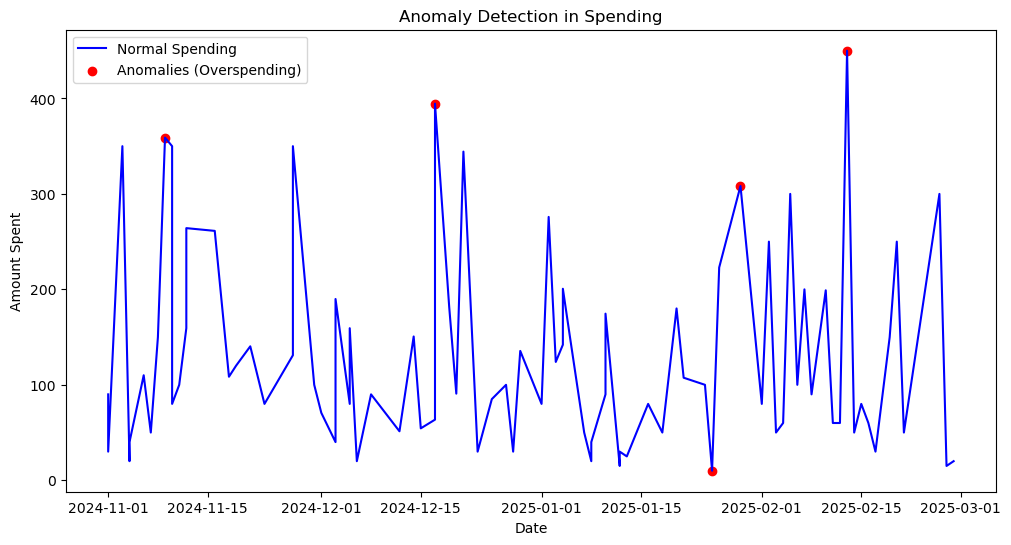

In [31]:
plt.figure(figsize=(12,6))
plt.plot(df["Date"], df["Amount"], label="Normal Spending", color="blue")
plt.scatter(anomalies["Date"], anomalies["Amount"], color="red", label="Anomalies (Overspending)", marker="o")
plt.xlabel("Date")
plt.ylabel("Amount Spent")
plt.title("Anomaly Detection in Spending")
plt.legend()
plt.show()


In [33]:
# Calculate mean and standard deviation for each category
category_stats = df.groupby('Category')['Amount'].agg(['mean', 'std']).reset_index()

# Merge with the original DataFrame
df = df.merge(category_stats, on='Category', how='left')

# Calculate rolling mean (7-day window) for each category
df['rolling_mean'] = df.groupby('Category')['Amount'].transform(lambda x: x.rolling(window=7).mean())


In [45]:
# Function to generate explanations
def generate_explanation(row):
    if row['Anomaly'] == -1:
        category_mean = row['mean']
        category_std = row['std']
        amount = row['Amount']
        
        # Calculate deviation from the mean
        deviation = ((amount - category_mean) / category_mean) * 100  # Percentage deviation
        
        if deviation > 0:
            return f"Your expense in '{row['Category']}' is {deviation:.2f}% higher than the usual trend."
        else:
            return f"Your expense in '{row['Category']}' is {-deviation:.2f}% lower than the usual trend."
    else:
        return "Normal"

# Add explanations to the DataFrame
df['explanation'] = df.apply(generate_explanation, axis=1)

# Display anomalies with explanations
anomalies = df[df['Anomaly'] == -1]  # Use -1 to filter anomalies
print("Detected Anomalies with Explanations:")
anomalies[['Date', 'Category', 'Amount', 'explanation']]


Detected Anomalies with Explanations:
         Date       Category  Amount  \
8  2024-11-09  Personal Care  358.97   
34 2024-12-17      Groceries  394.54   
62 2025-01-25      Utilities   10.00   
64 2025-01-29  Food & Dining  308.30   
76 2025-02-13  Personal Care  450.00   

                                          explanation  
8   Your expense in 'Personal Care' is 81.22% high...  
34  Your expense in 'Groceries' is 167.71% higher ...  
62  Your expense in 'Utilities' is 82.14% lower th...  
64  Your expense in 'Food & Dining' is 162.35% hig...  
76  Your expense in 'Personal Care' is 127.17% hig...  


,Date,Category,Amount,explanation
8,2024-11-09,Personal Care,358.97,Your expense in 'Personal Care' is 81.22% high...
34,2024-12-17,Groceries,394.54,Your expense in 'Groceries' is 167.71% higher ...
62,2025-01-25,Utilities,10.00,Your expense in 'Utilities' is 82.14% lower th...
64,2025-01-29,Food & Dining,308.30,Your expense in 'Food & Dining' is 162.35% hig...
76,2025-02-13,Personal Care,450.00,Your expense in 'Personal Care' is 127.17% hig...


In [37]:
print(df['Anomaly'].unique())

[ 1 -1]


In [47]:
df.to_csv('anomaly_detection_with_explanations.csv', index=False)